In [1]:
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

import matplotlib.pyplot as plt

from tqdm import tqdm

import joblib
import numpy as np 

In [ ]:
def permutation_importance_by_timestep(model, X_test, y_test, metric=mean_squared_error):
	"""
	Calcula a importância de cada time step com base na permutação dos valores de ambos os canais (features).
	"""
	base_pred = model.predict(X_test, verbose=0)
	base_score = metric(y_test, base_pred)

	timestep_importance = []

	for t in range(X_test.shape[1]):  # 80 time steps
		X_permuted = X_test.copy()
		# Permutar os valores do time step t em todas as amostras (para ambas as features)
		np.random.shuffle(X_permuted[:, t, 0])  # shuffle da feature 0 no passo t
		np.random.shuffle(X_permuted[:, t, 1])  # shuffle da feature 1 no passo t

		perm_pred = model.predict(X_permuted, verbose=0)
		perm_score = metric(y_test, perm_pred)

		importance = perm_score - base_score
		timestep_importance.append(importance)

	return np.array(timestep_importance)


def plot_timestep_importance_colored(importances):
	timesteps = np.linspace(.1, 1.5, 80)
	
	# Normaliza a importância para mapear nas cores
	norm = plt.Normalize(min(importances), max(importances))
	cmap = plt.cm.viridis
	colors = cmap(norm(importances))

	fig, ax = plt.subplots(figsize=(14, 5))  # Define o eixo principal explicitamente
	bars = ax.bar(timesteps, importances, width=.015, color=colors, edgecolor='black')

	# Adiciona valores sobre as barras
	for bar, val in zip(bars, importances):
		if val > importances.mean():
			ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
					f'{val:.2f}', ha='right', va='bottom', fontsize=9, rotation=0)

	# Adiciona a colorbar corretamente vinculada ao eixo
	sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])  # Necessário para o colorbar funcionar
	cbar = fig.colorbar(sm, ax=ax)
	cbar.set_label('Importância relativa')

	ax.set_title('Permutation Importance')
	ax.set_xlabel('Redshift (z)')
	ax.set_ylabel('Queda de desempenho')
	ax.grid(True, linestyle='--', alpha=0.4)

	plt.xticks(np.linspace(.1, 1.5, 7), np.round(np.linspace(.1, 1.5, 7), 2))

	plt.autoscale(False)
	plt.hlines(importances.mean(), 0, 1.6, colors='red', alpha=.4, linestyles='--')

	plt.tight_layout()
	plt.show()

	
def plot_timestep_importance(importances):
	plt.figure(figsize=(12, 4))
	plt.plot(np.linspace(.1, 1.5, 80), importances, marker='o')
	plt.title('Permutation Importance')
	plt.xlabel('Redshift (z)')
	plt.ylabel('Queda de desempenho')
	plt.grid(True, alpha=.3)
	plt.tight_layout()
	
	plt.xticks(np.linspace(.1, 1.5, 7), np.round(np.linspace(.1, 1.5, 7), 2))
	# plt.yticks(np.linspace(0, 2, 5), np.round(np.linspace(0, 2, 5), 2))

	plt.autoscale(False)
	plt.hlines(importances.mean(), 0, 1.6, colors='red', alpha=.4, linestyles='--')

	plt.show()


In [3]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
	data = np.load(f'input/data_{i+1}.npy')
	x.append(data[:, :2])
	y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

# Normalização
y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [00:03<00:00, 3219.07it/s]


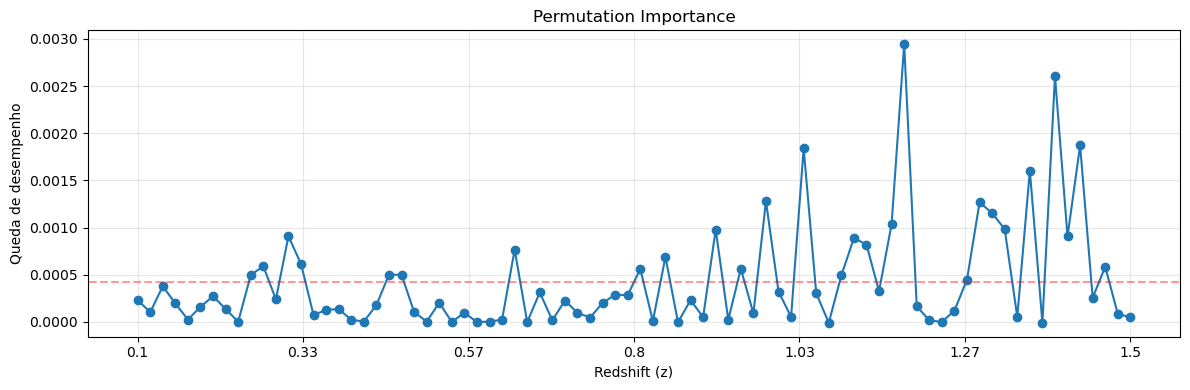

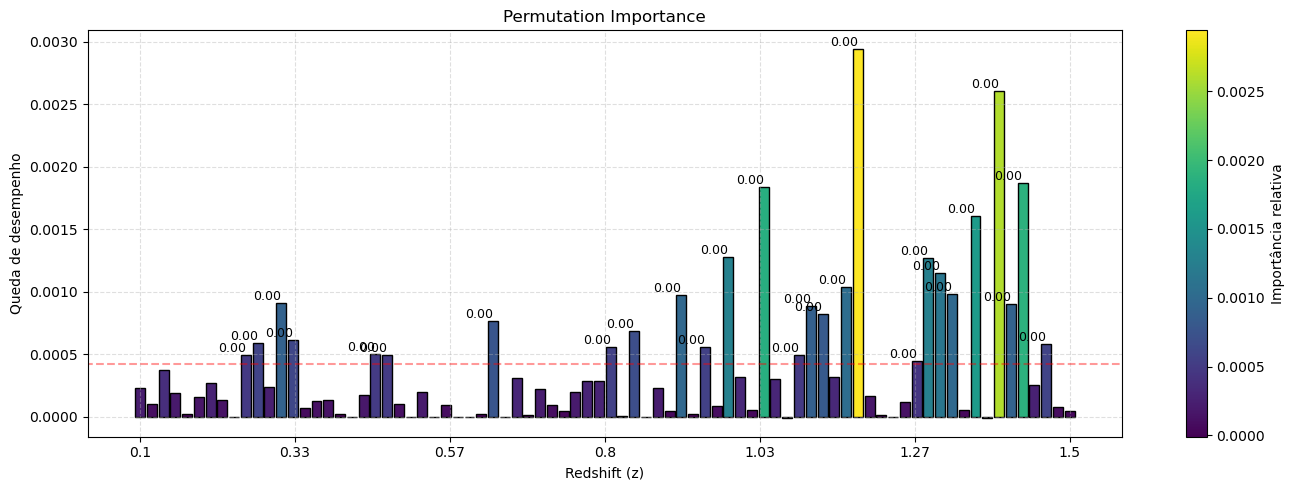

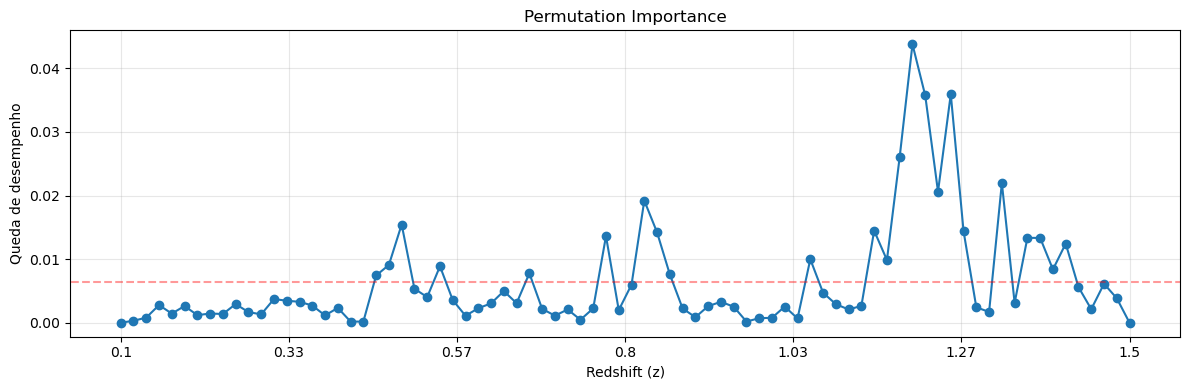

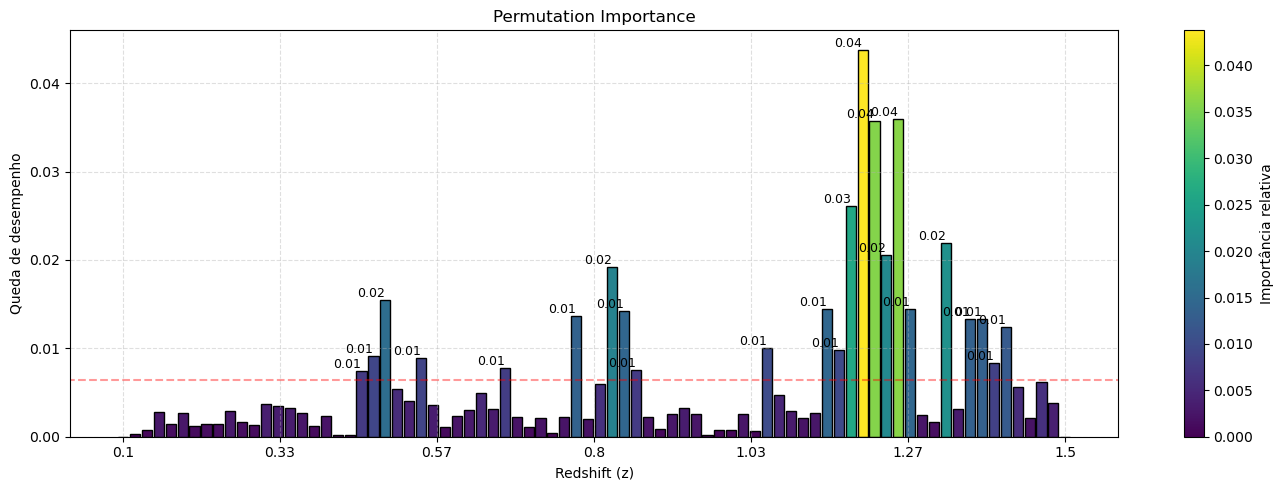

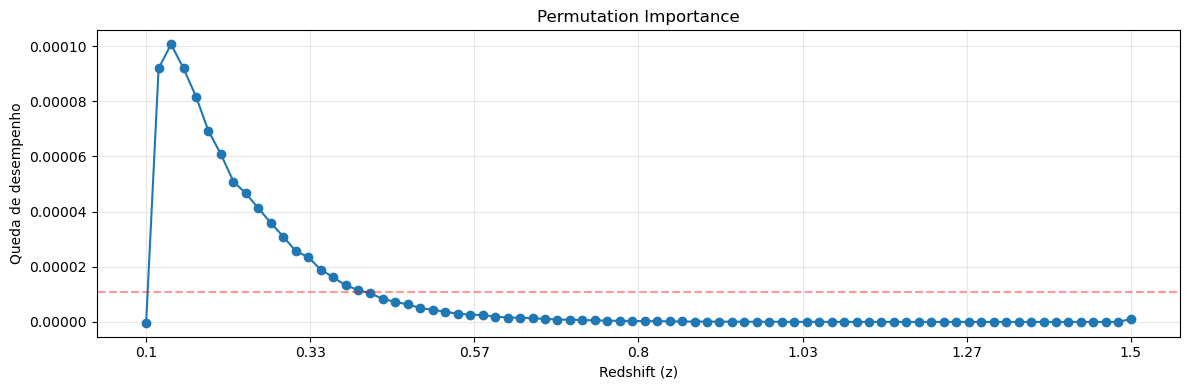

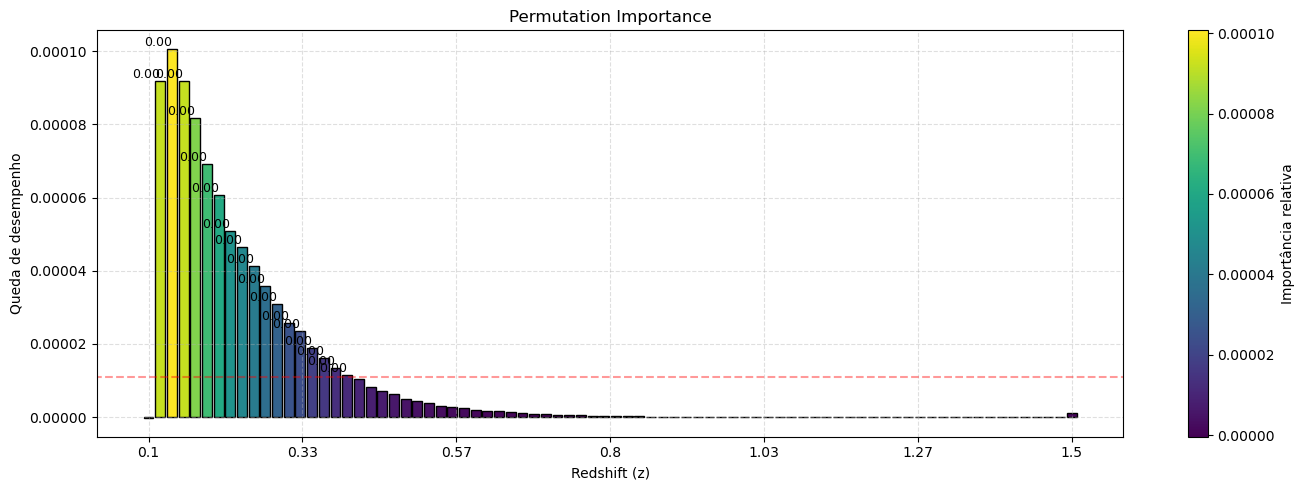

In [4]:
redes = ['dense', 'cnn', 'rnn']

for rede in redes:
    modelo = keras.models.load_model(f'models/{rede}')
    importances = permutation_importance_by_timestep(modelo, x_test, y_test)
    plot_timestep_importance(importances)
    plot_timestep_importance_colored(importances)
